# Load Shedding and Shifting Example

This example is a simple illustration that aims to explain the use of load shedding and load shifting in PyPSA. The example is designed to simulate a single day of electrical consumption in a small network with solar and wind generation, which could represent a single house or a small group of houses.

In [1]:
import pypsa
import matplotlib.pyplot as plt
import random
import datetime
import numpy as np
import pandas as pd

### Create network

In [2]:
network = pypsa.Network()

### Build the snapshots we consider for the first T hours in 2023


In [3]:
T = 24

network.set_snapshots(
    pd.to_datetime(
        [datetime.datetime(2023, 1, 1) + datetime.timedelta(hours=i) for i in range(T)]
    )
)
print(network.snapshots)

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)


### Add fuel types

In [4]:
network.add("Carrier", "solar")
network.add("Carrier", "wind")
network.add("Carrier", "load")
network.add("Carrier", "battery")

### Add buses

In [5]:
for i in range(4):
    network.add("Bus", "My bus {}".format(i))
# print(network.buses)

### Add lines

In [6]:
for i in range(4):
    network.add(
        "Line",
        "My line {}".format(i),
        bus0="My bus {}".format(i),
        bus1="My bus {}".format((i + 1) % 3),
        x=0.0001,
        s_nom=60,
    )

# print(network.lines)

### Add generators

Wind generation per unit of capacity is made random to represent random wind generation during the day.

Solar PV panel generation per unit of capacity is considered only in the daytime (8am-5pm)

"load" is added as a generator to represent load shedding, which is lowering the demand, thus increasing the generation. Load shedding is required when the network generation cannot satisfy the demand needed

In [7]:
# Add wind generation
rand_list = []
for i in range(24):
    rand_list.append(round(random.uniform(0.0, 1.0), 1))
network.add('Generator', 'wind', bus='My bus 0', p_nom=0.5, carrier="wind", p_max_pu=rand_list, marginal_cost=0+ 0.01* np.random.random())

# Add solar generation
pv_pu =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
 0.2, 0.4, 0.65, 0.85, 0.9, 0.85, 0.65, 0.4, 0.2, 0.1,
 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
network.add('Generator', 'solar', bus='My bus 2', p_nom=0.4, carrier="solar", p_max_pu=pv_pu, marginal_cost=0+ 0.01* np.random.random())

# Add load shedding as generator
network.add('Generator', 'load', bus='My bus 3', p_nom=50, carrier="load", p_max_pu=1.0, marginal_cost=1e2, p_nom_extendable=True)

### Add average hourly load values in a single day

In [8]:
load = [0.1, 0.2, 0.15, 0.14, 0.13, 0.14, 0.15, 0.2, 0.4, 0.6, 0.61, 0.58, 0.52, 0.53, 0.5, 0.51, 0.58, 0.7, 0.77, 0.81, 0.8, 0.79, 0.65, 0.48]
network.add('Load', 'Load 1', bus='My bus 1', p_set=load)

<AxesSubplot:xlabel='snapshot'>

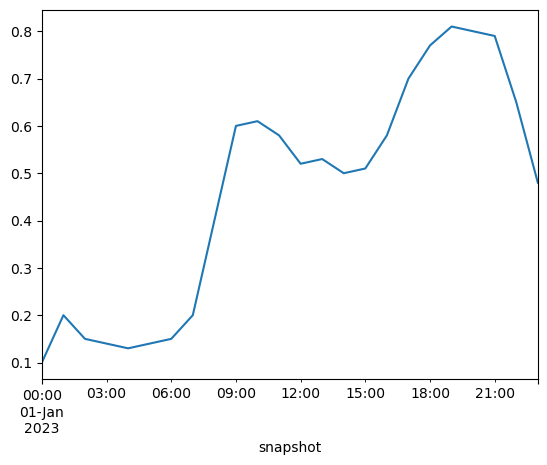

In [9]:
# Plot the load
network.loads_t.p_set['Load 1'].plot()

### Add storage units to the network

Storage units could be used to represent load shifting in PyPSA, where energy use is in peak hours is shifted to off-peak hours, which is a similar behaviour to discharging a storage unit in peak hours and charging it in off-peak hours.

Smart thermostats can shift the timing of energy use by automatically reducing heating or cooling during peak demand periods and increasing it during off-peak periods.

In [10]:
network.add("StorageUnit",
    'Smart thermostat',
    bus='My bus 3',
    p_nom=0,
    carrier="battery",
    marginal_cost=4 * np.random.random(),
    p_nom_extendable=True,
    p_max_pu=1,
    p_min_pu=-1,
    efficiency_store=0.9,
    efficiency_dispatch=0.95,
    standing_loss=0.01,
    cyclic_state_of_charge=True,
    max_hours=6,
    )

### Optimize the network and plot some results

In [11]:
network.lopf()

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.44s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e+02


('ok', 'optimal')

<AxesSubplot:xlabel='snapshot'>

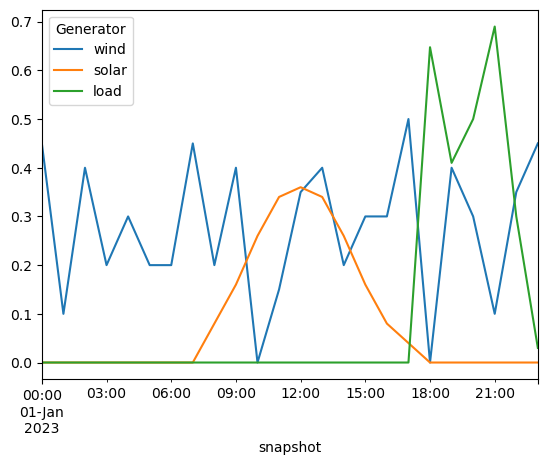

In [12]:
network.generators_t.p.plot()

<AxesSubplot:xlabel='snapshot'>

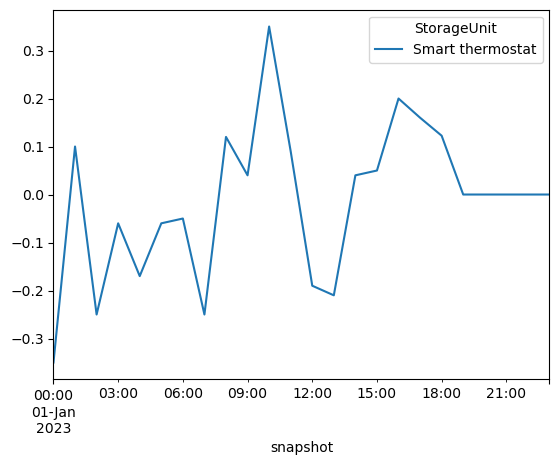

In [13]:
network.storage_units_t.p.plot()